Origin Images:


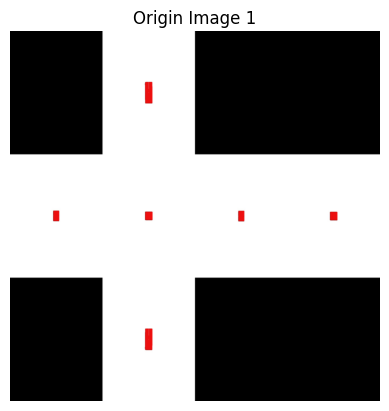

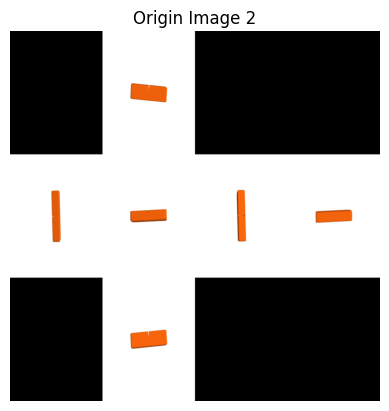

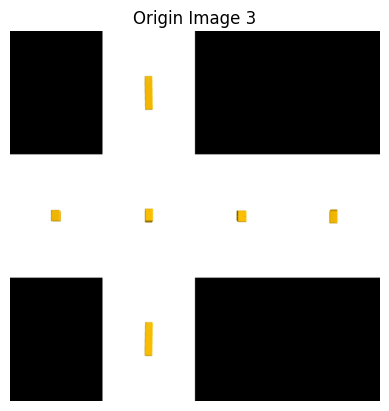

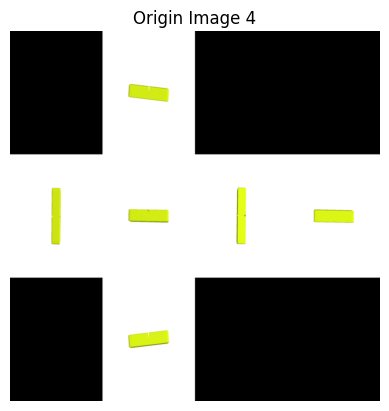

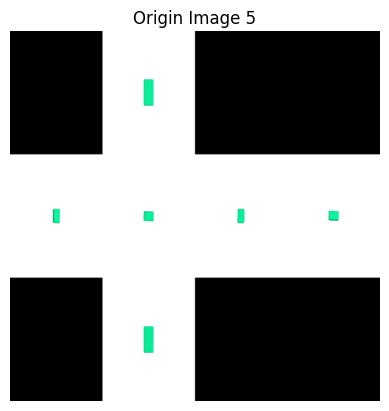

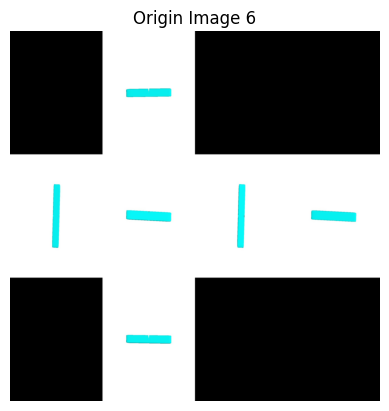

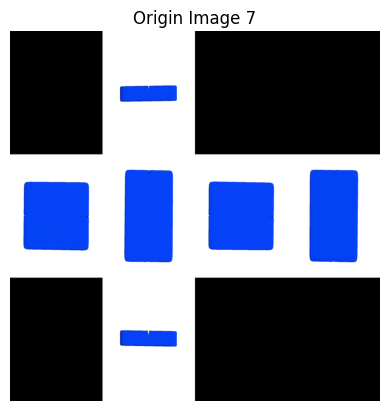

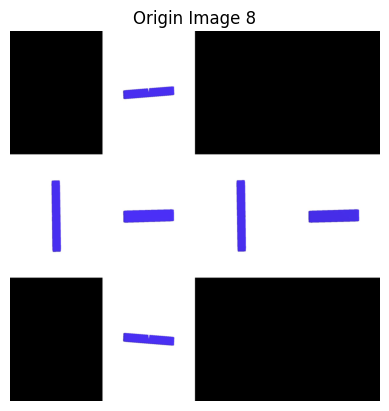

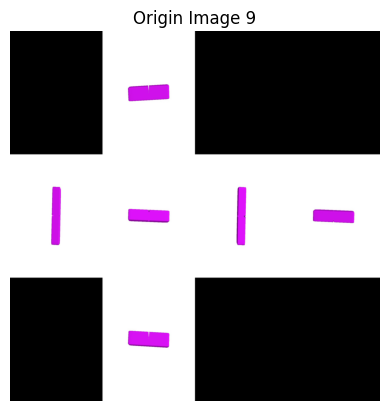

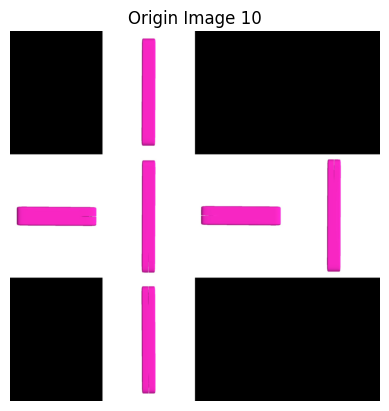

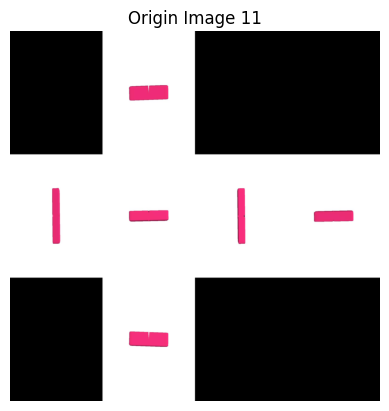

Target Images:


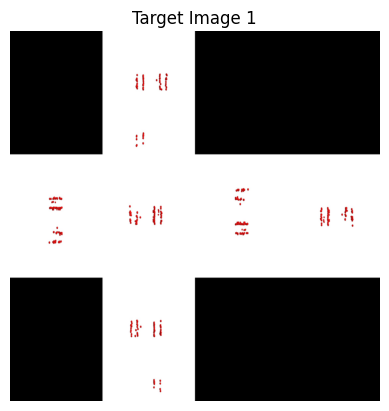

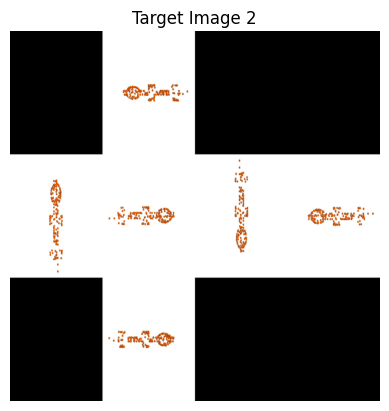

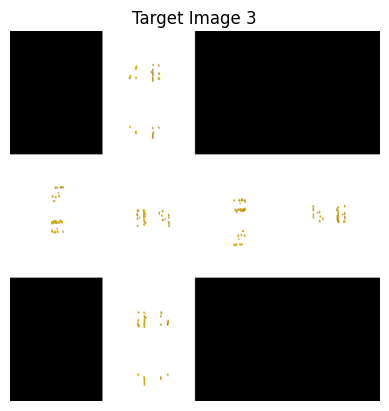

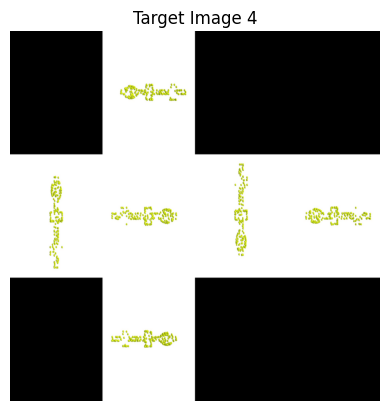

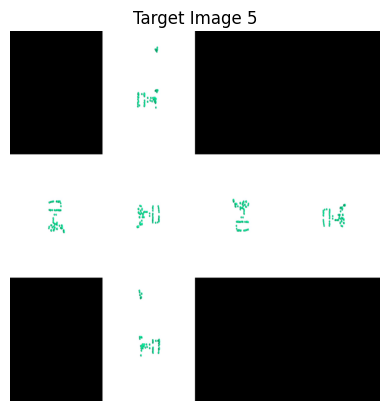

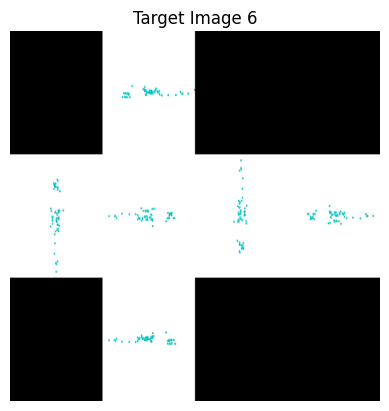

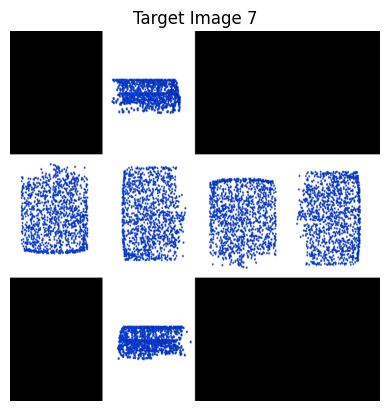

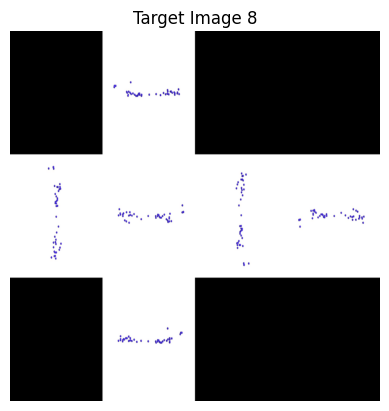

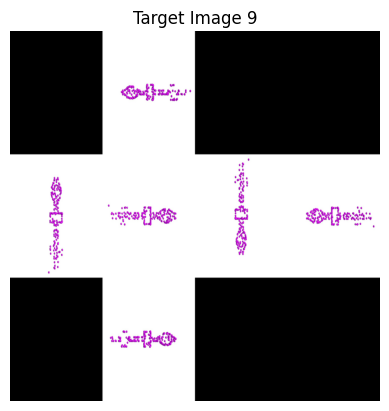

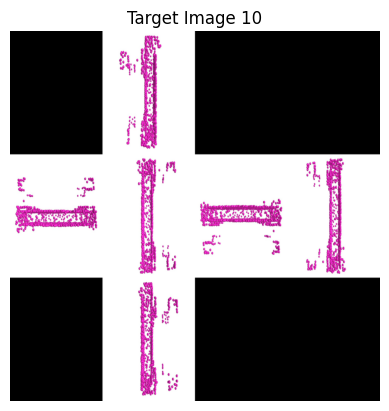

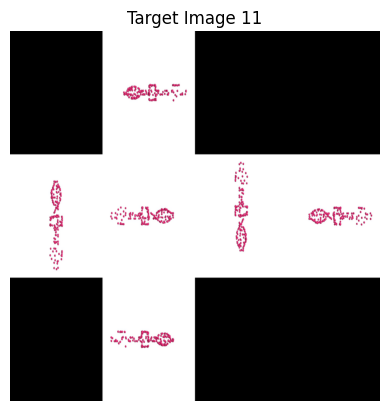

Complete Shape Image:


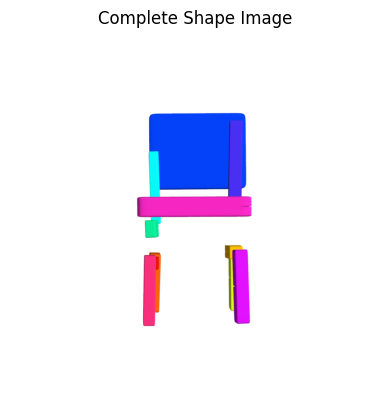

In [24]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Assuming CubeMapDataset class is already defined

# Instantiate the dataset
dataset = CubeMapDataset('../new_dataset.json')

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# Function to show images
def show_image(tensor, title="Image"):
    image = tensor.permute(1, 2, 0).cpu().numpy()
    image = (image + 1) / 2  # Convert [-1, 1] to [0, 1]
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Iterate through the DataLoader and print the output
for batch in dataloader:
    origin_images = batch['origin_images'][0]  # Remove batch dimension
    target_images = batch['target_images'][0]
    complete_shape_image = batch['complete_cuboid'][0]

    print("Origin Images:")
    for idx, img in enumerate(origin_images):
        show_image(img, title=f"Origin Image {idx+1}")

    print("Target Images:")
    for idx, img in enumerate(target_images):
        show_image(img, title=f"Target Image {idx+1}")

    print("Complete Shape Image:")
    show_image(complete_shape_image, title="Complete Shape Image")

    # Break after the first batch for testing purposes
    break


In [28]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

# Assuming CubeMapDataset class is already defined

# Instantiate the dataset
dataset = CubeMapDataset('../new_dataset.json')

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Function to show images in a single row
def save_images(complete_image, origin_image, target_image, shapenet_id, idx, output_dir):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    images = [complete_image, origin_image, target_image]
    titles = ["Complete Shape Image", f"Origin Image {idx+1}", f"Target Image {idx+1}"]

    for ax, img, title in zip(axes, images, titles):
        img = img.permute(1, 2, 0).cpu().numpy()
        img = (img + 1) / 2  # Convert [-1, 1] to [0, 1]
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')

    output_path = os.path.join(output_dir, f"{shapenet_id}_component_{idx+1}.png")
    plt.savefig(output_path)
    print(f"Saved: {output_path}")
    plt.close(fig)

# Output directory for saved images
output_dir = '/Users/cmazzoleni/Documents/SemesterProject/cube_map_dataset'
os.makedirs(output_dir, exist_ok=True)

# Iterate through the DataLoader and save the images
for batch in dataloader:
    shapenet_id = batch['shapenet_id'][0]  # Assuming 'shapenet_id' is a key in the batch
    origin_images = batch['origin_images'][0]  # Remove batch dimension
    target_images = batch['target_images'][0]
    complete_shape_image = batch['complete_cuboid'][0]

    for idx, (origin_img, target_img) in enumerate(zip(origin_images, target_images)):
        save_images(complete_shape_image, origin_img, target_img, shapenet_id, idx, output_dir)

    # Break after the first batch for testing purposes
    break



Saved: /Users/cmazzoleni/Documents/SemesterProject/cube_map_dataset/1ab4c6ef68073113cf004563556ddb36_component_1.png
Saved: /Users/cmazzoleni/Documents/SemesterProject/cube_map_dataset/1ab4c6ef68073113cf004563556ddb36_component_2.png
Saved: /Users/cmazzoleni/Documents/SemesterProject/cube_map_dataset/1ab4c6ef68073113cf004563556ddb36_component_3.png
Saved: /Users/cmazzoleni/Documents/SemesterProject/cube_map_dataset/1ab4c6ef68073113cf004563556ddb36_component_4.png
Saved: /Users/cmazzoleni/Documents/SemesterProject/cube_map_dataset/1ab4c6ef68073113cf004563556ddb36_component_5.png
Saved: /Users/cmazzoleni/Documents/SemesterProject/cube_map_dataset/1ab4c6ef68073113cf004563556ddb36_component_6.png


In [27]:
import os
import json
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class CubeMapDataset(Dataset):
    def __init__(self, json_file, resize_to_hw=(800, 800)):
        
        with open(json_file, 'r') as f:
            self.data = json.load(f)
        self.resize_to_hw = resize_to_hw

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        #add the relative path to the images
        path = "../dataset_cubemap/"
        origin_images = [self.load_image(os.path.join(path, component['cube_map'])) for component in item['component_origins']]
        target_images = [self.load_image(os.path.join(path,component['cube_map'])) for component in item['component_targets']]
        complete_shape_image = self.load_image(os.path.join(path,item['complete_cuboid']))
        #save shapenet_id
        shapenet_id = item['shapenet_id']

        return {
            'shapenet_id': shapenet_id,
            'origin_images': torch.stack(origin_images),
            'target_images': torch.stack(target_images),
            'complete_cuboid': complete_shape_image
            
        }

    def load_image(self, path):
        # Read image
        input_image = Image.open(path).convert('RGB')
        input_image = input_image.resize(self.resize_to_hw)
        image = np.asarray(input_image)
        
        # Convert image to tensor and normalize
        image_tensor = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0
        image_tensor = image_tensor * 2.0 - 1.0  # Normalize to [-1, 1]
        return image_tensor